# Personality

## Intro
The purpose of this notebook is to explore the relationship and possibility of making connecctions between the big five personality test and the "other" personality tests administered in the experiment. We first want to understand if and how results from the other tests can be used to determine ("predict") the students traits along the big five factors. These techniques can then be extended to forms other than surveys. The other area of interest is whether or not the "other" surveys describe some factors or traits or variance among the students that is NOT described by the big five personality factors. 

In [ ]:
!pip install --upgrade pandas
!pip install --upgrade sklearn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import SparsePCA, PCA
from sklearn.preprocessing import scale, normalize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [4]:
import personality
from personality import *

In [ ]:
from factor_rotation._wrappers import rotate_factors

In [ ]:
X = prep_X(read_surveys())
bf_survey = X.iloc[:, 0:65]
bf_survey_scaled = pd.DataFrame(scale(bf_survey))
others = X.iloc[:, 65:]
others_scaled = pd.DataFrame(scale(others))
ids = read_surveys().user_id

# Get the big five components, sparse positie loadings for the questions that
# refer to personality traits. 
bigfive_key = pd.read_csv("educatalyst/Auxil/q1_key_bigfive.csv")
bf_comps = get_big_five_comps(bigfive_key)

# Projec the survey data onto those big five personality components
bigfive = big_five_projection(bigfive_key, bf_survey)
bigfive_scaled = big_five_projection(bigfive_key, bf_survey_scaled)

In [5]:
bigfive.to_csv("clean_data/bigfive.csv", index=False)
bf_survey.to_csv("clean_data/bigfive_survey.csv", index=False)
others.to_csv("clean_data/others.csv", index=False)

## Regression

Predicting bigfive personality traits from the "other" surveys is treated as a multiple regression problem. 

The big five components are, as traditional, seen as latent factors achieved through linear combination in the original survey dimensions. In other words, the factors themselves exist within the dimensions of the original data, the creation of the factors being dot products, or projections, down into a subspace within the span of the surveys. For this reason, we start with a similar approach when attempting to translate from the space of the "other" surveys, looking for factors within the subspace of their span that relate to the big five factors. It is worth considering here, however, why this translation needs to be linear, or why the "big five" factor must be within a subspace spanned by these other surveys. This will be an even bigger question once we move on to forms of data that don't demand linear combinations in the same way (EEG, for example).

Given the small number of observations and high dimensions, we will definitely need to regularize, and as such we use cross-validation to tune those hyperparameters. The big five loadings are sparse, and the creators of these surveys create questions with the explicit intention of avoiding overlap, and as such we have reason to favor sparsity in the translation from "other" surveys to big five traits, which is why we use Elastic Net, cross validate the parameters, and pick those within the top 15% that are most aggressive on Sparsity. This is completely arbitrary. 

In [6]:
cv = KFold(3, random_state = 1, shuffle = True)
t = bigfive.as_matrix()[:, [0,1,2,4]]
m = GridSearchCV(MultiElasticNet(), 
                 {'alpha': np.arange(0.05, 1.5, .05), 
                  'l1_ratio': np.arange(0.2, 1.0, .05)}, 
                 cv = cv, 
                 scoring='neg_mean_squared_error')
res = pd.DataFrame(m.fit(others, t).cv_results_)

In [ ]:
# Visually inspect the top 15% performing params and pick the most aggresive. 
(res[res.mean_test_score > np.percentile(res.mean_test_score, 85) ]
 .sort_values(['param_l1_ratio', 'param_alpha'], 
              ascending = False)
 .head(20)[['params', 'mean_test_score']])

In [9]:
# Compare with the best params
m.best_score_, m.best_params_

(-2.7456783152161344,
 {'alpha': 0.55000000000000004, 'l1_ratio': 0.20000000000000001})

In [ ]:
# using the most agressive sparsity-inducing params from the top 15% cv'd scores
enet = MultiElasticNet(alpha = 0.4, l1_ratio = .5)
t = bigfive.as_matrix()
fitted = enet.fit(others, t)
reg_comps = normalize(enet.coef_).T

# Take a look at how sparse our loadings are:
cross_val_score(enet, others, t, cv = cv, scoring = 'neg_mean_squared_error').mean(), enet.coef_

## Validating the Regression

One often considers grades and scores to be consistent across monotone transformations, they are ordinal measures rather than cardinal ones. It is worth considering whether or not this applies here. Do we care about the accuracy of prediction in a cardinal sense, or do we care about maintaining the order of the students relative to each other? Beyond justathe order, does some maintainence of student-student distance matter, even regardless of cardinal discrepency?? 

For the ordinal case, we take a look at how well we maintain order along each factor by considering the Kendall Tau distance between the two orderings. This is simply the first idea I thought of. I have no idea how to put these scores in perspective. 

On the cardinal scale a natural starting place is the out-of-sample R^2, of course. The average across 3-fold validation is reported below.

For distance maintainence we explore simply comparing the distance matrices via their covariance-weighted L2 norm (mahalanobis distance).

The real question here is: how do we validate (and indeed, fit) our regression model. What is our cost? What is the most important? What constitutes an "accurate" mapping onto the big five personality traits?? 

In [ ]:
# do we want correlation coef or pvalue????? Is this bad or good??? 
compare_factors(one, bf_comps, others, reg_comps)

In [10]:
cross_val_score(enet, others, t, cv = cv)

array([ 0.41034834,  0.39969478,  0.42691796])

In [11]:
normed_reg_vectors = normalize(enet.coef_).T
bf_mapping = others.dot(normed_reg_vectors)

compare_distance(bigfive, bf_mapping)

0.3229679554549284

## Measuring Lost Variance

The other half of the exploration is an attempt to determine if there are other major aspects of the students' personalities that the "other" surveys are measuring that are LOST when it is all translated into the big five factors. 

To do this we try to compare the variance of the data (induced by a sparse PCA to regularize) with the variance of our big five projections, in both the big five surveys and the "others". 

In [12]:
def get_projected_variance(df, comps, p = 5):
    projected = df.dot(normalize(comps).T)
    v =  np.var(projected)/np.var(df).sum() * 100 
    print 'Summed variance of first %s components: %s' % (p,v[0:p].sum())
    return v

### In the space of the "Others" survey:

In [13]:
# Variance described by Big Five Regression from others survey space
get_projected_variance(others, enet.coef_)

Summed variance of first 5 components: 39.3411583718


0    8.672467
1    8.002980
2    8.666931
3    6.349644
4    7.649137
dtype: float64

In [352]:
# Variance described by pure PCA of others survey space
others_pca = PCA(5).fit(others_scaled)
# get_projected_variance(others, others_pca.components_)
A = others_pca.components_
V, T = rotate_factors(A.T, 'varimax')
np.stack([get_projected_variance(others_scaled, A), get_projected_variance(others_scaled, V.T)])

Summed variance of first 5 components: 46.0333921325
Summed variance of first 5 components: 46.0333921325


array([[ 18.40555681,  11.99694605,   6.14657412,   5.06260598,
          4.42170918],
       [ 13.9356478 ,   7.4355079 ,   7.79088151,   9.59363506,
          7.27771987]])

In [319]:
# projection of X into subspace of V
P = V.dot(V.T)
X_proj = others_scaled.dot(P)
np.allclose(X_proj, X_proj.dot(P))

bf_proj = bigfive.dot(bf_comps.T).shape

In [385]:
others_pca = PCA(5).fit(others_scaled)

A = others_pca.components_
V_orth, T = rotate_factors(A.T, 'varimax')
V, T = rotate_factors(A.T, 'oblimin', .635, 'oblique')


# Comparing the LL' - \Psi to \Sigma! <-- error rate to optimize?? This is for orthogonality??
dif = np.cov(others_scaled.T) - V.dot(V.T)
off_diag = dif - np.diag(np.diag(dif))
print np.linalg.norm(np.cov(others_scaled.T)), np.linalg.norm(off_diag)

# np.diag(np.mean(F.dot(F.T)))
# others_scaled.dot(A.T)
# normalize(V)
# fit the form of Ax = B, we need to transpose everything from our basic X = FL' form
F = np.linalg.lstsq(V, others_scaled.T)[0].T

# Ratio norm of difference between projected others_scaled
print 1 - np.linalg.norm(others_scaled - F.dot(V.T))/np.linalg.norm(others_scaled)
# Ratio of variane between projected and others_scaled
print 1 - np.var(others_scaled - F.dot(V.T)).sum() / np.var(others_scaled).sum()

# This is only the same if we go with orthogonal factors!
# F = others_scaled.dot(V)

# Look at loadings matrix just like in Norman paper :D
print np.round(V * 100)

10.1224800384 4.21183043173
0.265380316984
0.460333921325
[[-31.   2. -45.  21. -20.]
 [-11.  -5. -31.   9.  40.]
 [-43.  10. -15. -31.   1.]
 [ -4.   7. -60.  18.  31.]
 [ 35.  -2. -14. -19.  26.]
 [ 28.   7.  20. -27.  29.]
 [ -4.  46.  12. -18.  24.]
 [ -6.  28. -20.  -6.  39.]
 [-55.   6. -13. -21.  -5.]
 [ 20.  -2. -15. -19.  68.]
 [-51.  11. -25. -19. -14.]
 [ 15.  15. -40.  -1.  42.]
 [ 19.  -4. -36.  -3.  35.]
 [-14.  41. -35.   8.  22.]
 [-28.  10.  34. -34. -14.]
 [  4.   1.  29. -49.  17.]
 [-12.   1.   6. -49.   3.]
 [ 13.  19.  -9.  -1.  47.]
 [-39.  25.   8. -22. -25.]
 [-66.  16. -16.  -9.   2.]
 [-34.  -3.   3. -41. -15.]
 [-26.  63.   4.  -1.   2.]
 [-22.  -8. -55.  -1.  13.]
 [-68.  15. -14.  -9. -13.]
 [ -2.  34. -13.   1.  48.]
 [ -8. -15.  -3. -28.  43.]
 [-58.  14.  -4. -13. -15.]
 [ 12. -23.   0. -54.  31.]
 [-33.   4.   6. -55.  22.]
 [-18.   6.  39. -54.  10.]
 [-22.  38.   2.  -9.  23.]
 [-10. -35.   4. -49.  -2.]
 [ -3.  28.   1. -12.  48.]
 [-40. -10. -45.  

In [366]:
# In both cases, that of the big five survey and that of our others survey,
# there seems to be a single strong "general" component that is highly correlated
# with all the factors from the bigfive. This could definitely indicate a
# misspecification of the surveys themselves. 

bf_survey_pca = PCA(5).fit(bf_survey_scaled)
loadings = bf_survey_pca.components_.T
V, T = rotate_factors(loadings, 'varimax')
VO, T = rotate_factors(loadings, 'oblimin', .635, 'oblique')
# V = loadings
bf_pca_factors = bf_survey_scaled.dot(V)
corr = np.corrcoef(bf_pca_factors, bigfive, rowvar=False)
# sns.heatmap(pd.DataFrame(corr).iloc[0:5,0:10])
# plt.show()
pd.DataFrame(VO)

           0         1         2         3         4
0   0.114428 -0.081999 -0.423778 -0.026029  0.043355
1   0.066159 -0.011704 -0.341921 -0.114547  0.028553
2  -0.359705 -0.020380  0.053662 -0.209056  0.074850
3   0.072969 -0.328216 -0.197691 -0.124829  0.014553
4  -0.324387 -0.008756 -0.040283 -0.128075  0.155258
5  -0.100529 -0.296094 -0.072126  0.272613  0.045509
6  -0.446333 -0.099313  0.104699 -0.152686  0.005371
7  -0.291759 -0.046438  0.135697  0.223330  0.144850
8  -0.144988  0.116285 -0.042289  0.190535  0.305285
9  -0.110010  0.053348 -0.075334 -0.088001  0.170248
10 -0.161549  0.055493 -0.107693 -0.438585  0.001047
11 -0.452604 -0.043516  0.061166  0.001803  0.220291
12 -0.051169 -0.210754 -0.301298 -0.043990  0.127700
13 -0.034758  0.145170 -0.167720 -0.103952  0.332482
14 -0.086849 -0.197467  0.005752  0.187919  0.302238
15 -0.062796 -0.338078 -0.276417 -0.049188 -0.109744
16 -0.056524 -0.257906 -0.104384  0.358548  0.153357
17 -0.412771 -0.013902  0.049078 -0.061842  0.

In [346]:
corr = np.corrcoef(F, bigfive, rowvar=False)
p = sns.heatmap(pd.DataFrame(corr).iloc[0:5,0:10])
plt.show()

In [ ]:
from factor_rotation._analytic_rotation import target_rotation

T = target_rotation(F, bigfive)
rotated_factors = F.dot(T≈
corr = np.cov(rotated_factors, bigfive, rowvar = False)
sns.heatmap(corr)
plt.show()

In [ ]:
from scipy.spatial.distance import cosine, pdist, squareform
from factor_rotation._gpa_rotation import GPA


T = GPA(F, )
rotated_factors = F.dot(T)
# f,b = [np.array(df) for df in [rotated_factors, bigfive]]
# cos = squareform(pdist(np.concatenate([f.T,b.T]), 'cosine'))
# sns.heatmap(cos)
# plt.show()
# sum([cos[1,6], cos[2,7], cos[4,9], cos[3,8]])

In [ ]:
from sklearn.decomposition import DictionaryLearning

others_dict = DictionaryLearning(5).fit(others_scaled)

In [ ]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components = 38)
res = cca.fit_transform(bf_survey, others)
bf_ccas = res[0]
others_ccas = res[1]
# get_projected_variance(bf_survey.T, bf_ccas.T), get_projected_variance(others.T, others_ccas.T)

In [25]:
F = others.dot(others_pca.components_.T)
# F.dot(others.T)
F.shape, others.shape

((94, 5), (94, 38))

In [280]:
# Variance described by Sparse PCA in others survey space
others_sparse_pca = SparsePCA(8, .8).fit(others)
get_projected_variance(others, others_sparse_pca.components_)

Summed variance of first 5 components: 40.7414493917


0    10.629493
1    10.414766
2     7.607404
3     5.766579
4     6.323208
5     5.765240
6     4.522215
7     7.120568
dtype: float64

### In the space of the Big Five survey:

In [ ]:
# Variance described by Big Five Regression from others survey space
get_projected_variance(others, enet.coef_)

In [ ]:
# Variance explained by official Big Five Mapping
get_projected_variance(bf_survey, bf_comps.T)

# varimax gives reasonable results here, leaves everything unchanged... 
# V,T = rotate_factors(bf_comps.T, 'varimax')
# bf_comps.T - V


In [310]:
# Variance explained by pure PCA
bf_survey_pca = PCA(5).fit(bf_survey)
# get_projected_variance(bf_survey, bf_survey_pca.components_)
A = bf_survey_pca.components_
V, T = rotate_factors(A, 'varimax')
# get_projected_variance(bf_survey, V)
# np.round(V*10000)

In [283]:
# Variance explained by Sparse PCA
bf_survey_sparse_pca = SparsePCA(8, .8).fit(bf_survey)
get_projected_variance(bf_survey, bf_survey_sparse_pca.components_)

Summed variance of first 5 components: 41.7959663825


0     6.954491
1    12.506588
2     5.411025
3     9.582842
4     7.341020
5     6.396424
6     4.112881
7     7.628662
dtype: float64

## Considering the scaling of the Big Five Factors

Do we center and scale to the columns, to the answers given for each question? Not doing so assumes that they are already centered/scaled to a population and the differences we see are unique to our population here. Doing so assumes that our population here is a representative sample of the types we need these transformations to work for. 

In [380]:
dist_scaled = pairwise_distances(bigfive, metric = 'mahalanobis')
dist_five2 = pairwise_distances(bigfive_scaled, metric = 'mahalanobis')
get_diff(dist_scaled, dist_five2)

0.035187536092504995

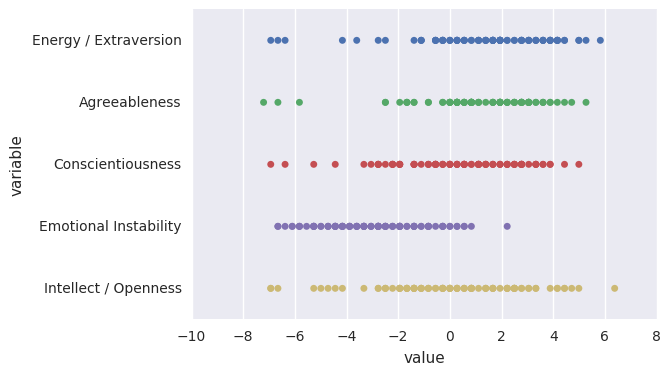

In [476]:
sns.stripplot(x = 'value', y = 'variable', data = bigfive.melt(), orient = 'h')

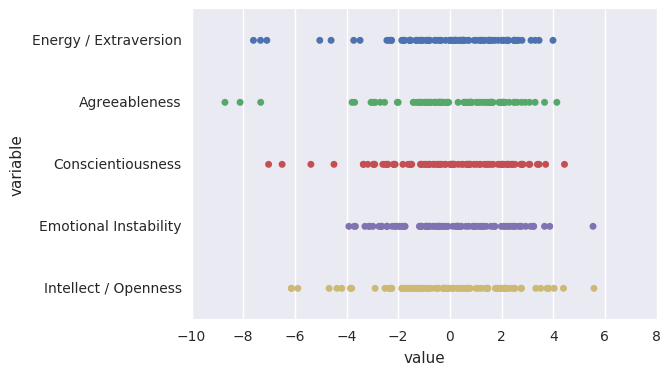

In [517]:
sns.stripplot(x = 'value', y = 'variable', data = bigfive_scaled.melt(), orient = 'h')

## How do they match?

Just taking a quick look at what questions in the "others" survey go to what question in the big five personality factors.

In [518]:
bigfive_key.bigfive_lbl_eng.unique()

array(['Energy / Extraversion', 'Agreeableness', 'Conscientiousness',
       'Emotional Instability', 'Intellect / Openness'], dtype=object)

In [521]:
get_questions(reg_comps, 0.1)

[           0                                                  1
 0   0.522327                       I�m a very motivated person.
 1  -0.132643     I�m good at getting along with my classmates. 
 2   0.128962               I�m comfortable with the way I look.
 3   0.475185  I can make other people feel better when I wan...
 4   0.190995  I find it hard to cope when things change in m...
 5   0.238734                      I�m able to deal with stress.
 6   0.111701                           I�m happy with my life. 
 7   0.388803     I would describe myself as a good negotiator. 
 8   0.217601                          I feel good about myself.
 9   0.358623         I�m able to cope well in new environments.
 10  0.149036                          I finish whatever I begin,
            0                                                  1
 0   0.144065  It�s easy for me to talk about my feelings wit...
 1   0.575243                       I�m a very motivated person.
 2   0.453594  I can mak